# Linear Regression

# Posterior distribution _(of regression parameters),_ and 
# Posterior predictive distribution _(of new $y$ predictions)._

<h2 style="color:green">JAGS version</h2>

# _Josep Fortiana_ $\hskip6cm$ 2022-04-25

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\expdist{\operatorname{Exp}}$
$\def\fdist{\operatorname{F}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\invgammadist}{IG}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\normaldist{\operatorname{N}}$
$\def\unifdist{\operatorname{Unif}}$
$\def\xbar{\kern1.3pt\overline{\kern-1.3pt x}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
$\def\eqdef{\stackrel{\text{def}}{\mskip3mu=\mskip3mu}}$
***

# 01. Simple linear regression: A simulated example

## Generate a simulated dataset for simple linear regression

In [1]:
# More or less arbitrary parameters for the data generation
trueA<-1   
trueB<-5
trueSd<-15
n<-20
sampleSize<-n 

In [2]:
# Uniformly spread x values in the interval [-n/2,n/2]
x<-(-(sampleSize-1)/2):((sampleSize-1)/2)
# y values of the form a + b*x + N(0,trueSd)
set.seed(123123)
y<-trueA+trueB*x+rnorm(n=sampleSize,mean=0,sd=trueSd)

In [3]:
# Plot data points plus the line used in the generation
# Note this line is NOT a regression line, which will be computed below
# It is just an auxiliary line, used to generate the dataset
options(repr.plot.width=7, repr.plot.height=7)
plot(x,y,pch='+',cex=0.9,col="blue",main="Test data for simple linear regression ",cex.main=1.7)
abline(trueA,trueB,lwd=3.5,col="cyan")

## Fit a (classical) least squares linear regression model

In [4]:
lm.1<-lm(y~x)
options(repr.plot.width=7, repr.plot.height=7)
plot(x,y,pch='+',cex=1.1,col="blue",main="Linear regression with test data",cex.main=1.5)
yhat<-fitted.values(lm.1)
abline(trueA,trueB,lwd=3.5,col="cyan")
abline(lm.1,lwd=3.5,col="blue")
points(x,yhat,pch=16,col="red",cex=1.4)
legend("topleft",c("Original    ","","Regression   ","","Fitted points"), lwd=3.5,
       col=c("cyan","white","blue","white","red"),cex=1.1)

## Extract information from the fitted model

In [5]:
print(lm.1)


Call:
lm(formula = y ~ x)

Coefficients:
(Intercept)            x  
      2.507        4.222  



In [6]:
summary(lm.1)


Call:
lm(formula = y ~ x)

Residuals:
    Min      1Q  Median      3Q     Max 
-14.140  -5.951  -3.854   3.507  24.248 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.5066     2.6939   0.930    0.364    
x             4.2224     0.4672   9.038 4.13e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12.05 on 18 degrees of freedom
Multiple R-squared:  0.8194,	Adjusted R-squared:  0.8094 
F-statistic: 81.69 on 1 and 18 DF,  p-value: 4.135e-08


### Regression coefficients

In [7]:
Coeff<-coefficients(lm.1)
a.hat<-Coeff[1]
b.hat<-Coeff[2]
round(a.hat,3)
round(b.hat,3)

(Intercept) 
      2.507

x 
4.222

### Predict the response for a new $\tilde{x}$

In [8]:
x.tilde<-c(2.5,3)  # just for example
newx<-data.frame(x=x.tilde)

In [9]:
predict(lm.1,newdata=newx)

1        2 
13.06277 15.17400

By default for linear models `type=response`

In [10]:
predict(lm.1,newdata=newx,interval = "confidence")

fit      lwr      upr     
1 13.06277 6.894112 19.23143
2 15.17400 8.794218 21.55377

Confidence intervals for fitted values

$$
    \hat{y}=\hat{a}+\hat{b}\cdot\tilde{x}
$$

In [11]:
predict(lm.1,newdata=newx,interval="prediction")

fit      lwr       upr     
1 13.06277 -12.98873 39.11427
2 15.17400 -10.92830 41.27629

Confidence intervals for predicted values, including the $\normaldist(0,\sigma^{2})$ fluctuation around $\hat{y}$.    
(so the results are wider intervals)

# 02. Simple linear regression: Bayesian model

The purpose of fitting a model in this case is to explore the relationship between $y$ and $ x$. Since both $y$ and $x$ are continuous, a simple regression line is a good start.

Each observed response ($y_{i}$) is assumed to be drawn from a normal distribution with mean ($\mu_{i}$) and standard deviation ($\sigma$). 

The expected values ($\mu_{i}$) are themselves determined by the linear predictor ($\beta_{0}+\beta\cdot x_{i}$). In this case, $\beta_{0}$ represents the $y$-intercept (value of $y$ when $x$ is equal to zero) and $\beta$ represents the rate of change in $y$ for every unit change in $x$ (the effect).

We will employ weakly informative _("non informative")_ priors. This choice is always a bit of a balancing act. If the priors are too vague (wide) the MCMC sampler can wander off into nonsense areas of likelihood rather than concentrate around areas of highest likelihood (desired when wanting the outcomes to be largely driven by the data). On the other hand, if the priors are too strong, they may have an influence on the parameters. In such a simple model, this balance is very forgiving - it is for more complex models that prior choice becomes more important.

For this simple model, we will go with Gaussian (normal) priors with relatively large standard deviations (1000) for both the intercept and the treatment effect and a wide uniform for the standard deviation. 
The intercept $\beta_{0}$  will be centered at $\hat{a}$ (`a.hat`), the least squares intercept and the slope will be zero centered. Alternatively we could center $x$ and $y$ beforehand and then use a zero-centered prior for  $\beta_{0}$ too.

The model, likelihood $+$ priors, is:

$$
\begin{array}{lcl}
    y_{i}     &\sim &\normaldist(\mu_{i},\sigma^2),\\[0.2cm]
    \mu_{i}   &=    &\beta_{0}+\beta\cdot x_{i},\\[0.2cm]
    \beta_{0} &\sim &\normaldist(\,0\,,1000^2),\\[0.2cm]
    \beta     &\sim &\normaldist(\,0\,,1000^2),\\[0.2cm]
    \sigma    &\sim &\unifdist(0,100).
\end{array}
$$

<h3 style="color:red"> Posterior prediction </h3>

<div style="color:red">
    
We will generate (a sample of) the posterior predictive pdf for each of the $n$ predictor values. By the same procedure we could generate a posterior
predictive pdf for any new set of new $x$ values.   
    
$$
\begin{array}{lcl}
    \mu^{\text{POST}}_{i}   &=    &\beta^{\text{POST}}_{0}+\beta^{\text{POST}}\cdot x_{i},\\[0.2cm]
    y^{\text{POST}}_{i}     &\sim &\normaldist(\mu_{i}^{\text{POST}},{\sigma^{2}}^{\text{POST}}).
\end{array}
$$
    
</div>

## JAGS translation

**Remembering that in JAGS normal pdf's are specified with the precision parameter $\tau=1/\sigma^{2}$.**

$$
\begin{array}{lcl}
    y_{i}     &\sim &\operatorname{N}(\mu_{i},\tau),\\[0.2cm]
    \mu_{i}   &=    &\beta_{0}+\beta\cdot x_{i},\\[0.2cm]
    \tau      &=    &1/\sigma^2,\\[0.2cm]
    \beta_{0} &\sim &\normaldist(\,0\,,1.0E-6),\mskip10mu\text{noninformative prior,}\\[0.2cm]
    \beta     &\sim &\normaldist(\,0\,,1.0E-6),\mskip10mu\text{noninformative prior,}\\[0.2cm]
    \sigma    &\sim &\unifdist(0,100),\mskip10mu\text{noninformative prior.}
\end{array}
$$

## JAGS code

We will run the JAGS via the R2jags interface. 

Some authors recommend to run any kind of randomization function just to initiate the `.Random.seed` variable the first time `jags` is run after the `R2jags` package is loaded 
(just as we tend to do with `set.seed()` in R.

In [12]:
#install.packages("R2jags",dependencies=TRUE,repos= "https://cloud.r-project.org")
require(R2jags)

Loading required package: R2jags

Loading required package: rjags

Loading required package: coda

Linked to JAGS 4.3.1

Loaded modules: basemod,bugs


Attaching package: 'R2jags'


The following object is masked from 'package:coda':

    traceplot




In [13]:
simple.regression.pred.JAGS.01.modelString= "
    model{
      #Likelihood
    for (i in 1:n){
        y[i]~dnorm(mu[i],tau)
        mu[i] <- b.0+b.1*x[i]
        }
  
    #Priors
    b.0 ~ dnorm(0.0,1.0E-6)
    b.1 ~ dnorm(0.0,1.0E-6)
    tau<-pow(sigma,-2)          
    sigma~dunif(0,100)

    # Posterior predictive distributions
    # Since this is a small dataset we compute a posterior predictive pdf for 
    # each x in the original set.
    # In fact we could have used any set of x's (or just a single one)

    for (i in 1:n){
        y.pred[i]~dnorm(mu.post[i],tau)
        mu.post[i] <- b.0+b.1*x[i]
        }
  }"

## write the model to text file 
writeLines(simple.regression.pred.JAGS.01.modelString, con = "./simple.regression.pred.JAGS.01.jag")

### Data list

Arrange the data as a list (as required by JAGS). As input, JAGS will need to be supplied with:

- The response variable ($y$)
- The predictor variable ($x$)
- The total number of observed items ($n$)
- The  mean of the prior for $\beta_{0}$

This all needs to be contained within a list object. 

In [14]:
simple.regression.pred.JAGS.01.data.list <- list(y = y, x = x, n = sampleSize)

### Define initial values

Define the initial values of $\beta_{0}$, $\beta_{1}$ and $\sigma$ for the chain. Reasonable starting points can be gleaned from the data themselves. 

#### Note

This step is not absolutely necessary for simple models as the `R2jags` interface will automatically create sensible initial values for the parameters based on simple data summaries.

On the other hand it is possible to define (random) functions to generate different initial ppoints on each run.

In [15]:
simple.regression.pred.JAGS.01.inits<-rep(list(list(b.0=a.hat, b.1 = b.hat, sigma = sd(y))), 3)

### Define the MCMC chain parameters

Next we should define the behavioural parameters of the MCMC sampling chains. Include the following:

- The nodes (estimated parameters) to monitor (return samples for)
- The number of MCMC chains (3)
- The number of burnIn steps (3000)
- The thinning factor (10)
- The number of MCMC iterations - determined by the number of samples to save, the rate of thinning and the number of chains

In [16]:
params <- c("b.0", "b.1", "sigma","mu.post","y.pred")
nChains = 3
burnInSteps = 3000
thinSteps = 10
numSavedSteps = 15000  #across all chains
nIter = ceiling(burnInSteps + (numSavedSteps * thinSteps)/nChains)
nIter

[1] 53000

## Fitting the model 

In [17]:
simple.regression.pred.JAGS.01.m<- jags(data = simple.regression.pred.JAGS.01.data.list, 
                             inits = simple.regression.pred.JAGS.01.inits, 
                            parameters.to.save = params, model.file = "./simple.regression.pred.JAGS.01.jag",
                            n.chains = nChains, n.iter = nIter, n.burnin = burnInSteps, n.thin = thinSteps)

module glm loaded



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 20
   Unobserved stochastic nodes: 23
   Total graph size: 110

Initializing model



In [18]:
print(simple.regression.pred.JAGS.01.m)

Inference for Bugs model at "./simple.regression.pred.JAGS.01.jag", fit using jags,
 3 chains, each with 53000 iterations (first 3000 discarded), n.thin = 10
 n.sims = 15000 iterations saved
            mu.vect sd.vect    2.5%     25%     50%     75%   97.5%  Rhat n.eff
b.0           2.535   2.947  -3.307   0.616   2.550   4.444   8.316 1.001 15000
b.1           4.227   0.507   3.225   3.894   4.231   4.556   5.230 1.001 15000
mu.post[1]  -37.619   5.629 -48.748 -41.336 -37.620 -33.932 -26.469 1.001 15000
mu.post[2]  -33.392   5.203 -43.673 -36.829 -33.385 -29.982 -23.104 1.001 15000
mu.post[3]  -29.165   4.794 -38.570 -32.330 -29.175 -26.022 -19.628 1.001 15000
mu.post[4]  -24.939   4.405 -33.560 -27.838 -24.946 -22.041 -16.181 1.001 15000
mu.post[5]  -20.712   4.042 -28.655 -23.379 -20.719 -18.071 -12.677 1.001 15000
mu.post[6]  -16.485   3.713 -23.755 -18.918 -16.483 -14.083  -9.150 1.001 15000
mu.post[7]  -12.258   3.428 -19.020 -14.469 -12.241 -10.040  -5.492 1.001 15000
mu.post[8

## Convert output to an `mcmc` object for diagnostics and further analysis

In [19]:
simple.regression.pred.JAGS.01.mcmc<-as.mcmc(simple.regression.pred.JAGS.01.m)
summary(simple.regression.pred.JAGS.01.mcmc)


Iterations = 3001:52991
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                Mean      SD Naive SE Time-series SE
b.0           2.5354  2.9466 0.024059       0.024671
b.1           4.2268  0.5074 0.004143       0.004127
deviance    157.6346  2.7737 0.022647       0.022250
mu.post[1]  -37.6189  5.6288 0.045959       0.044540
mu.post[10]   0.4221  2.9554 0.024131       0.024805
mu.post[11]   4.6488  2.9595 0.024165       0.023993
mu.post[12]   8.8756  3.0493 0.024897       0.025094
mu.post[13]  13.1024  3.2175 0.026271       0.026535
mu.post[14]  17.3291  3.4527 0.028191       0.028577
mu.post[15]  21.5559  3.7423 0.030556       0.030769
mu.post[16]  25.7827  4.0748 0.033270       0.033535
mu.post[17]  30.0095  4.4404 0.036256       0.036570
mu.post[18]  34.2362  4.8317 0.039451       0.039814
mu.post[19]  38.4630  5.2430 0.042809       0.043219
mu.pos

In [16]:
#str(simple.regression.pred.JAGS.01.mcmc)

In [20]:
#install.packages("bayesplot",dependencies=TRUE,repos= "https://cloud.r-project.org")
require(bayesplot)

Loading required package: bayesplot

This is bayesplot version 1.9.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting



### Traceplot

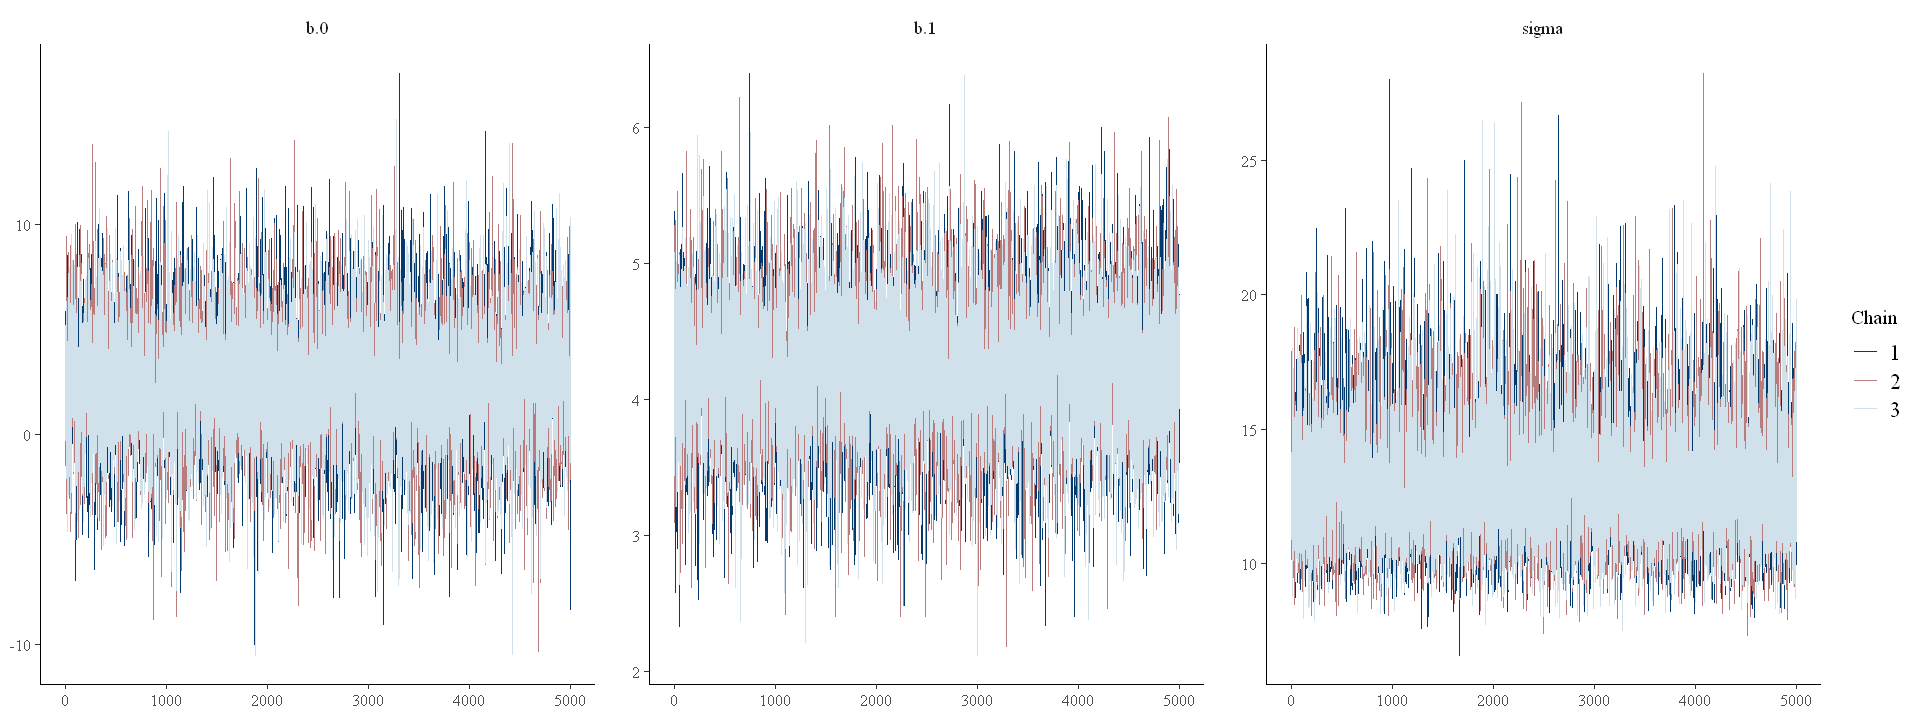

In [21]:
options(repr.plot.width=16, repr.plot.height=6)
color_scheme_set("mix-blue-red")
mcmc_trace(simple.regression.pred.JAGS.01.mcmc, pars = c("b.0","b.1","sigma"))

### Autocorrelation plot

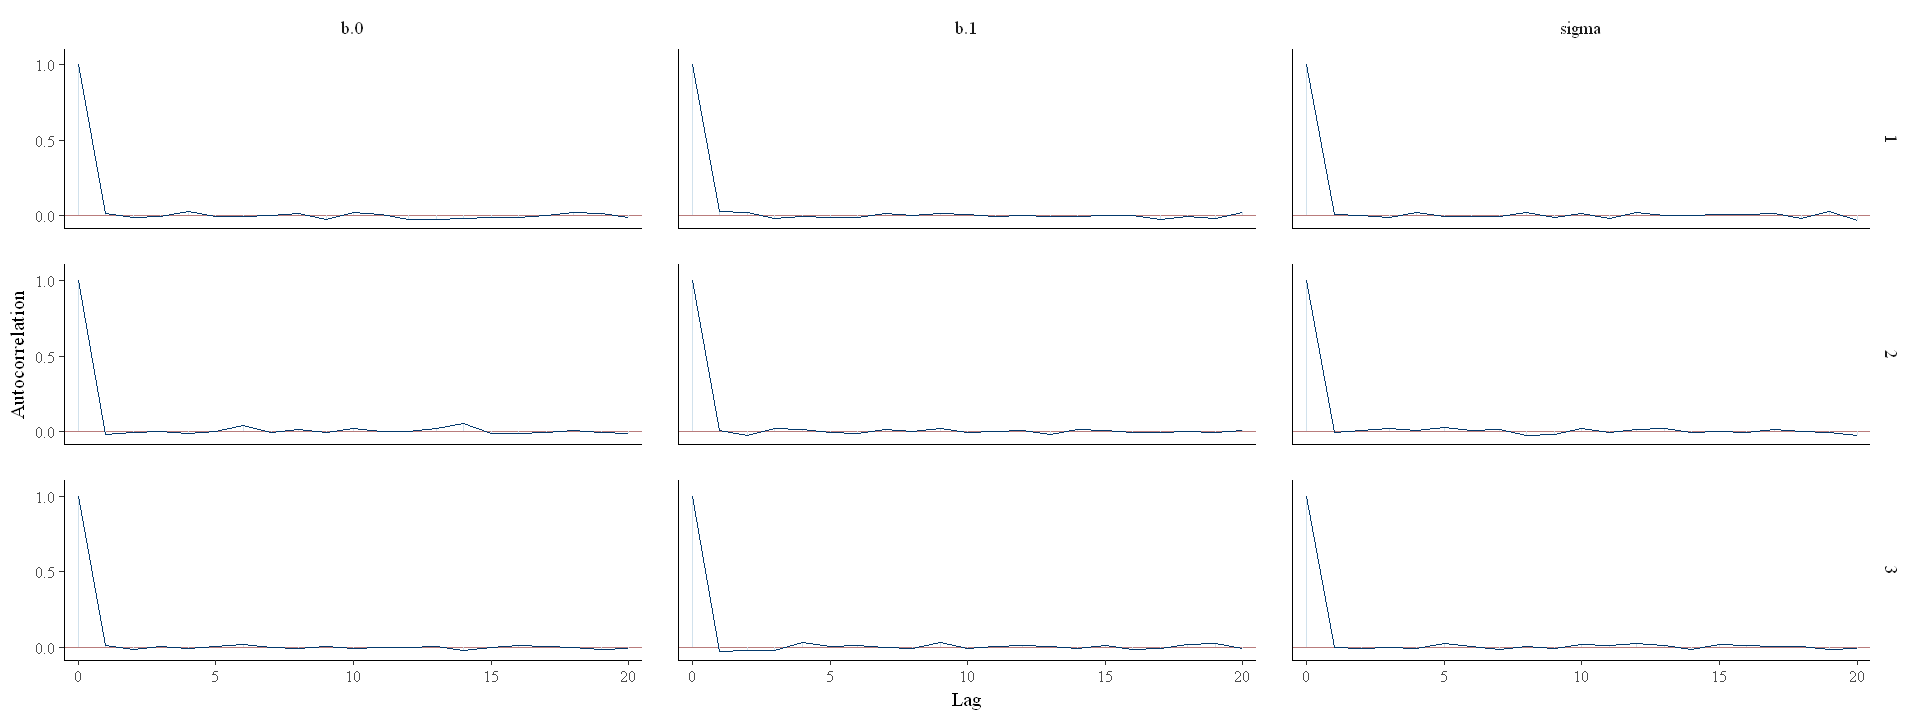

In [22]:
options(repr.plot.width=16, repr.plot.height=6)
color_scheme_set("mix-blue-red")
mcmc_acf(simple.regression.pred.JAGS.01.mcmc, pars = c("b.0","b.1","sigma"))

###  Posterior area plots (posterior density + posterior credible intervals)

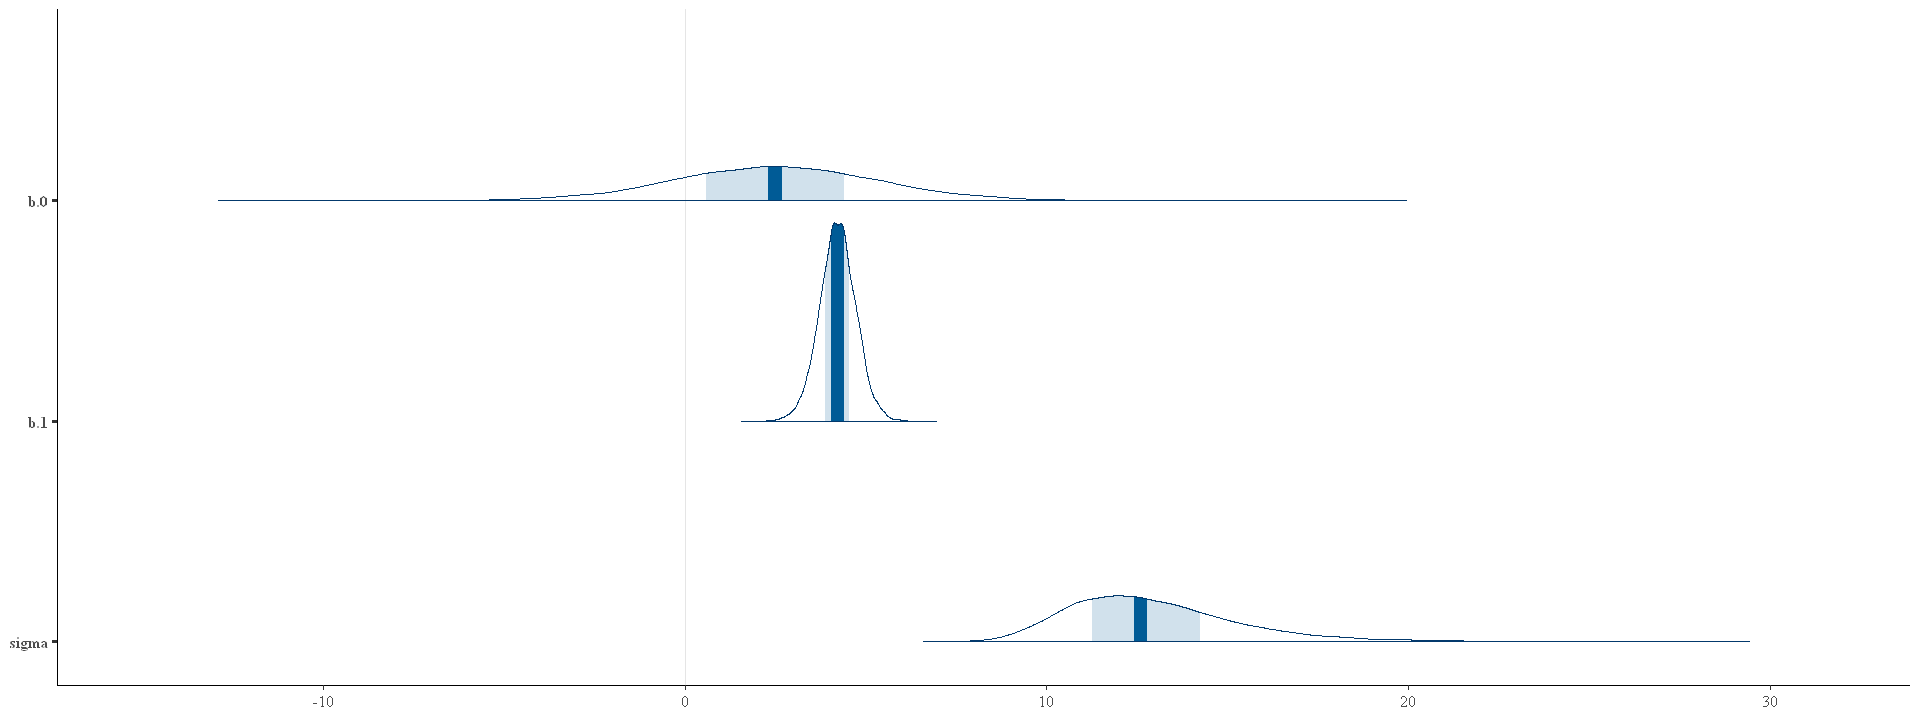

In [19]:
options(repr.plot.width=16, repr.plot.height=6)
color_scheme_set("mix-blue-red")
mcmc_areas(simple.regression.pred.JAGS.01.mcmc, pars = c("b.0","b.1","sigma"))

Problem with plotting parameters together is, either range or dispersion can be quite different.

Then one can plot them separately to better visualize.

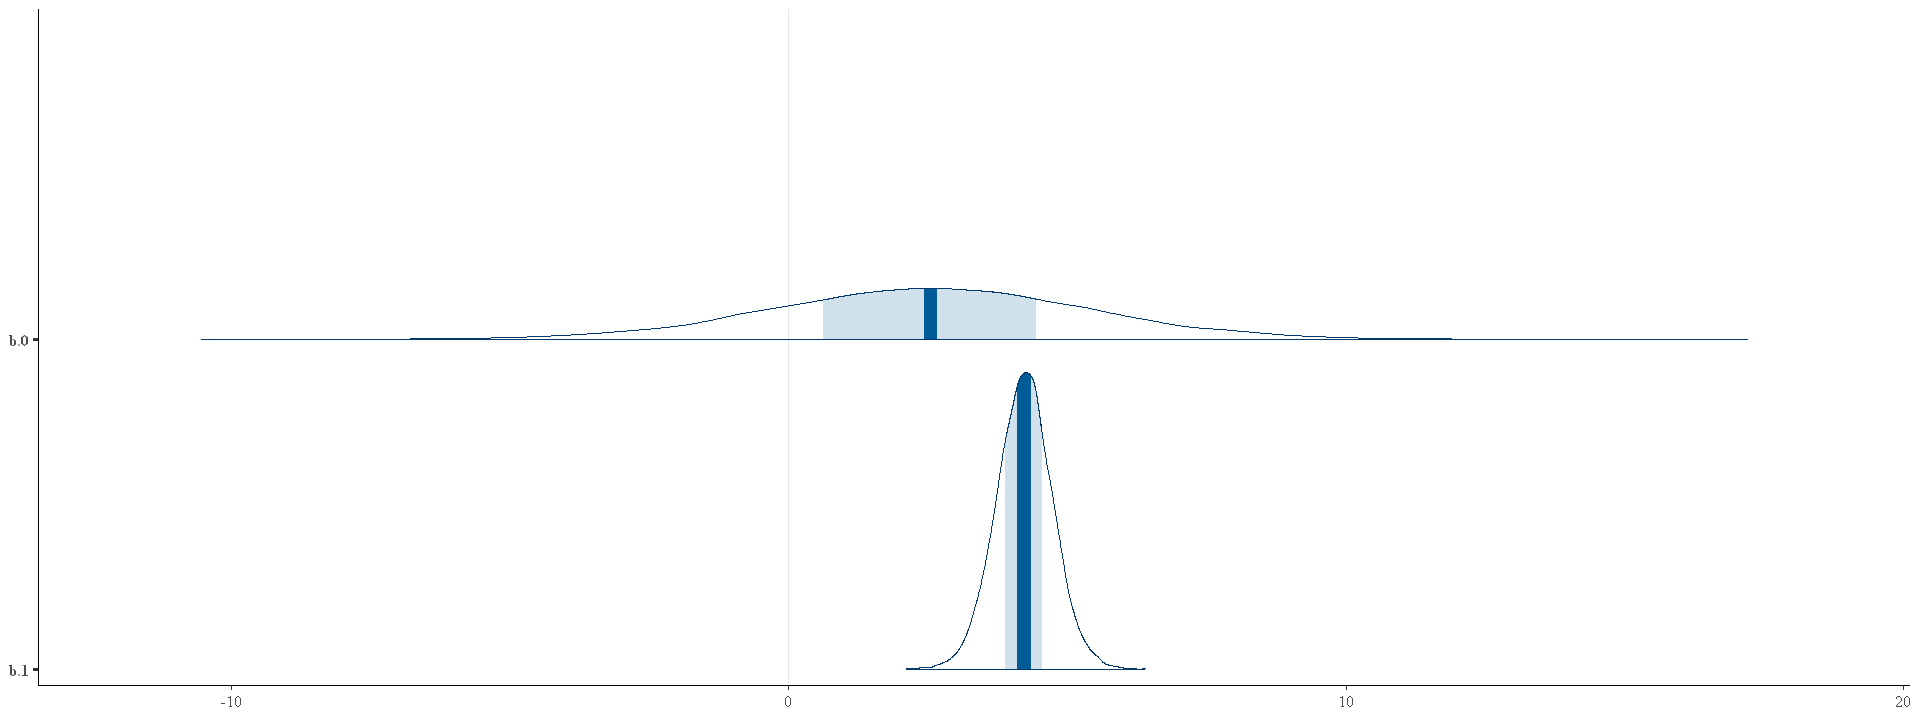

In [23]:
options(repr.plot.width=16, repr.plot.height=6)
color_scheme_set("mix-blue-red")
mcmc_areas(simple.regression.pred.JAGS.01.mcmc, pars = c("b.0","b.1"))

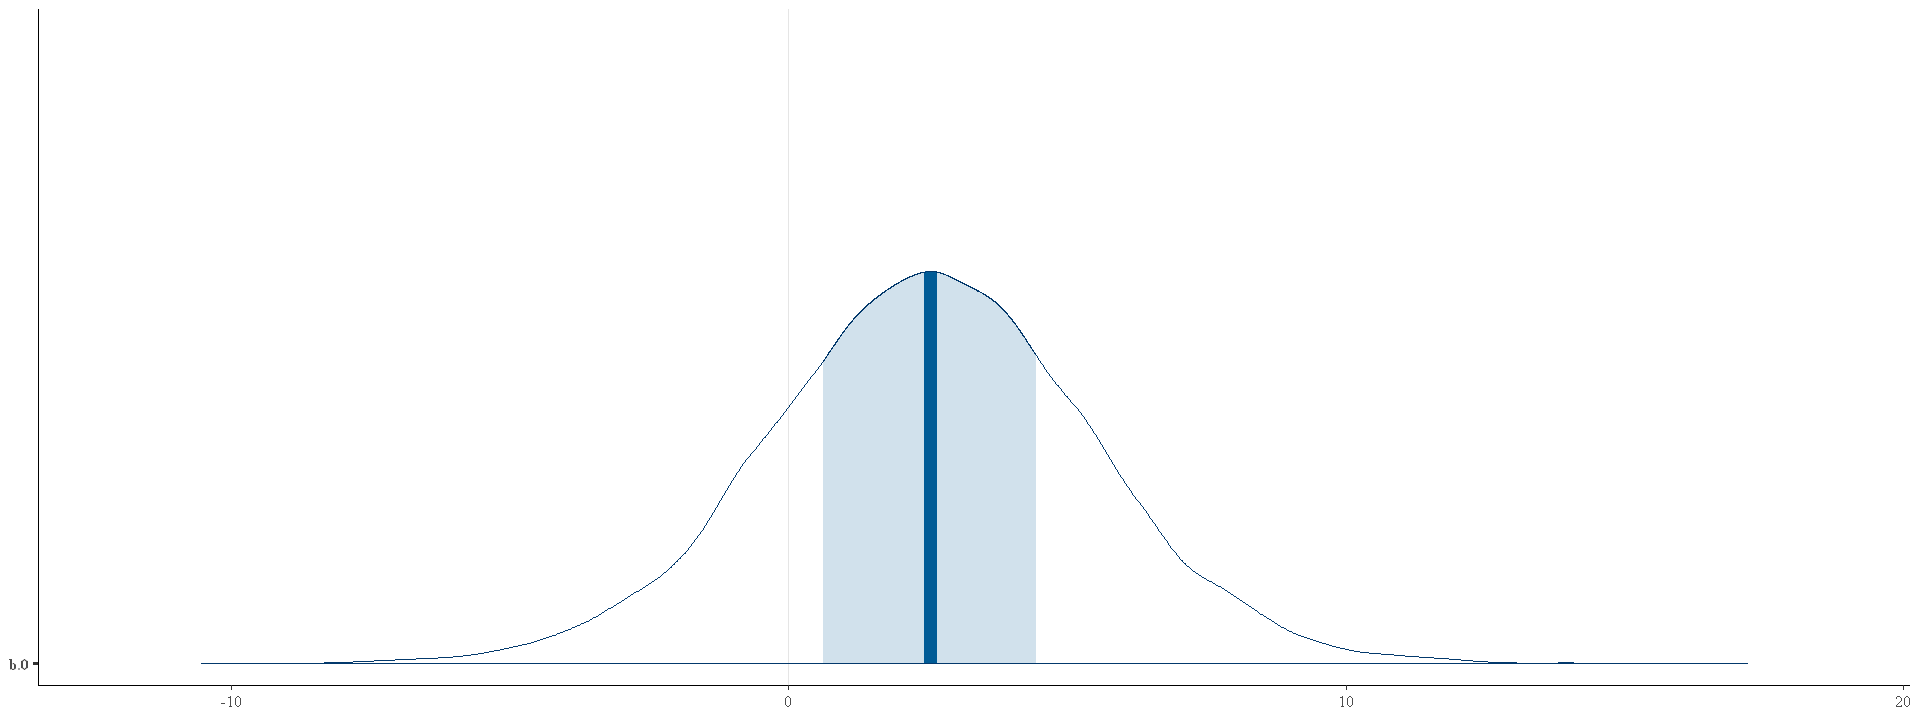

In [24]:
options(repr.plot.width=16, repr.plot.height=6)
color_scheme_set("mix-blue-red")
mcmc_areas(simple.regression.pred.JAGS.01.mcmc, pars = c("b.0"))

###  Posterior density plots

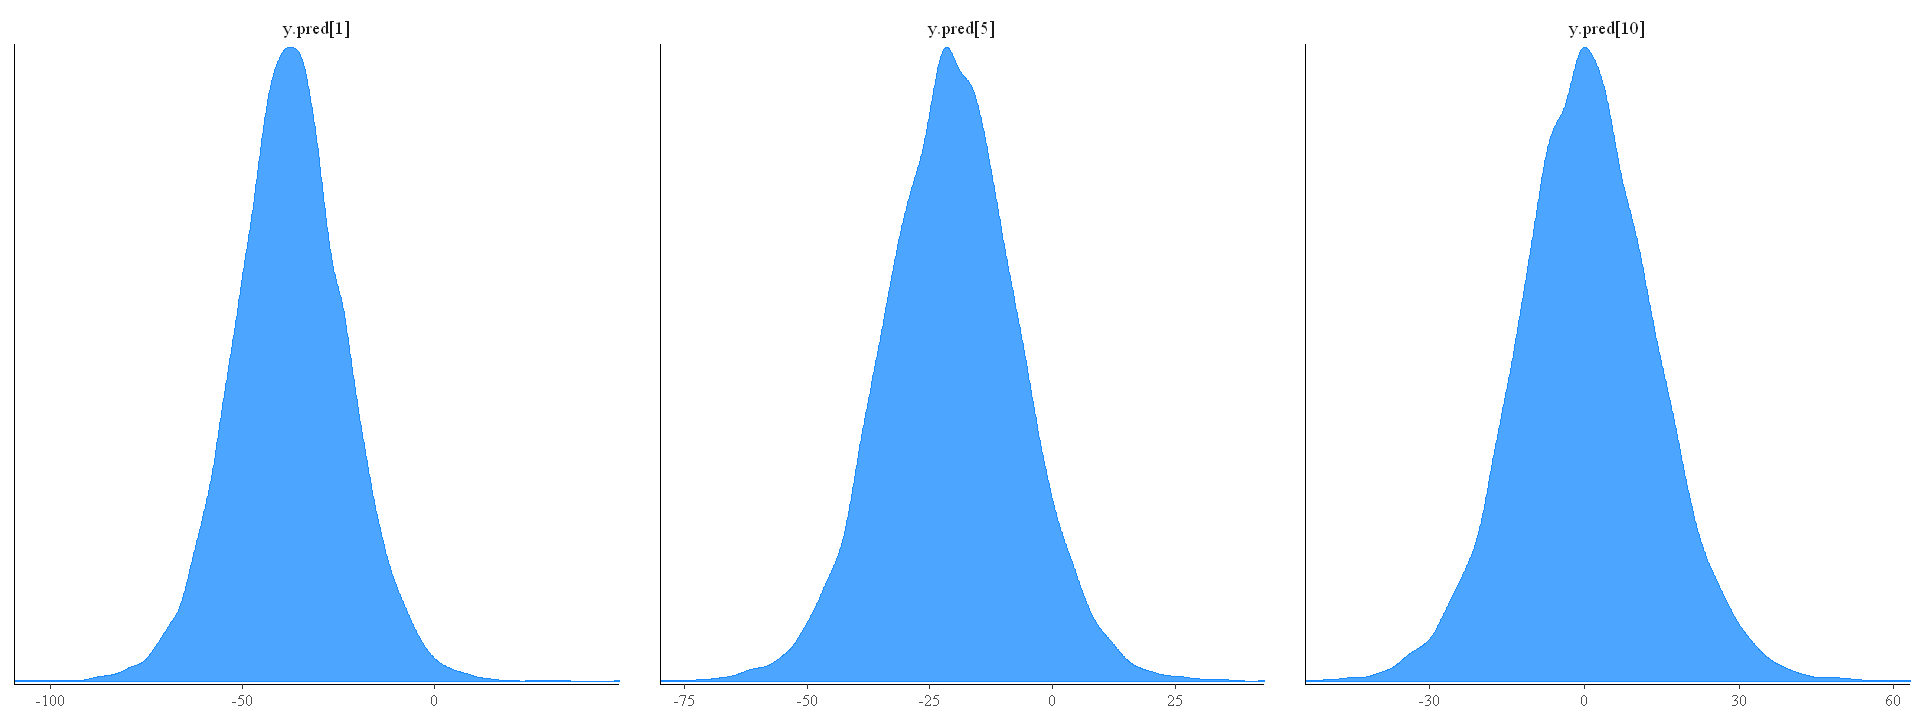

In [25]:
options(repr.plot.width=16, repr.plot.height=6)
color_scheme_set("brightblue")
mcmc_dens(simple.regression.pred.JAGS.01.mcmc, pars = c("y.pred[1]","y.pred[5]","y.pred[10]"))

# 03. The `Advertising` dataset

From [An Introduction to Statistical Learning with Applications in R (ISLR)](https://www.statlearning.com/). 

File [`Advertising.csv`](https://www.statlearning.com/s/Advertising.csv) from the textbook web page. 

In this section we follow the treatment of the `Advertising` dataset from chapters 2 and 3.

Suppose that we are statistical consultants hired by a client to investigate  the  association  between 
advertising  and  sales  of  a  particular product.  The  `Advertising`  data  set  consists  of  the  
sales  of  that  product in 200 different markets, along with advertising budgets for the product in each 
of those markets for three different media: TV, radio, and newspaper.  It  is  not  possible  for  our  
client  to directly increase sales of the product. On the other hand, they can control the advertising
expenditure  in  each  of  the  three  media.  Therefore,  if  we determine that there 
is an association between advertising and sales, then we can instruct our client to adjust 
advertising budgets, thereby indirectly increasing sales.

In other words, our goal is to develop an accurate model that can be used to predict sales on the basis of the three media budgets.
In this setting, the advertising budgets are  input  variables  while sales is an output  variable. 
The input variables are typically denoted using the symbol $X$, with a subscript to distinguish them. So $X_{1}$ might be the TV budget, 
$X_{2}$ the radio  budget, and $X_{3}$ the newspaper  budget. The inputs go by different names, such as _predictors,_
_independent variables,_ _features,_ or sometimes just _variables._ The output variable —in this case, sales— is often 
called the _response_  or _dependent  variable,_ and is typically denoted using the symbol $Y$.

### Read dataset.

Omit first column, the index of each sample. If needed it could be recovered by: `row.names(Advertising)`.

In [30]:
Advertising<-read.csv("Advertising.csv")
#Advertising<-read.csv("https://www.statlearning.com/s/Advertising.csv")
Advertising<-Advertising[,-1]  # This line, if read from local .csv

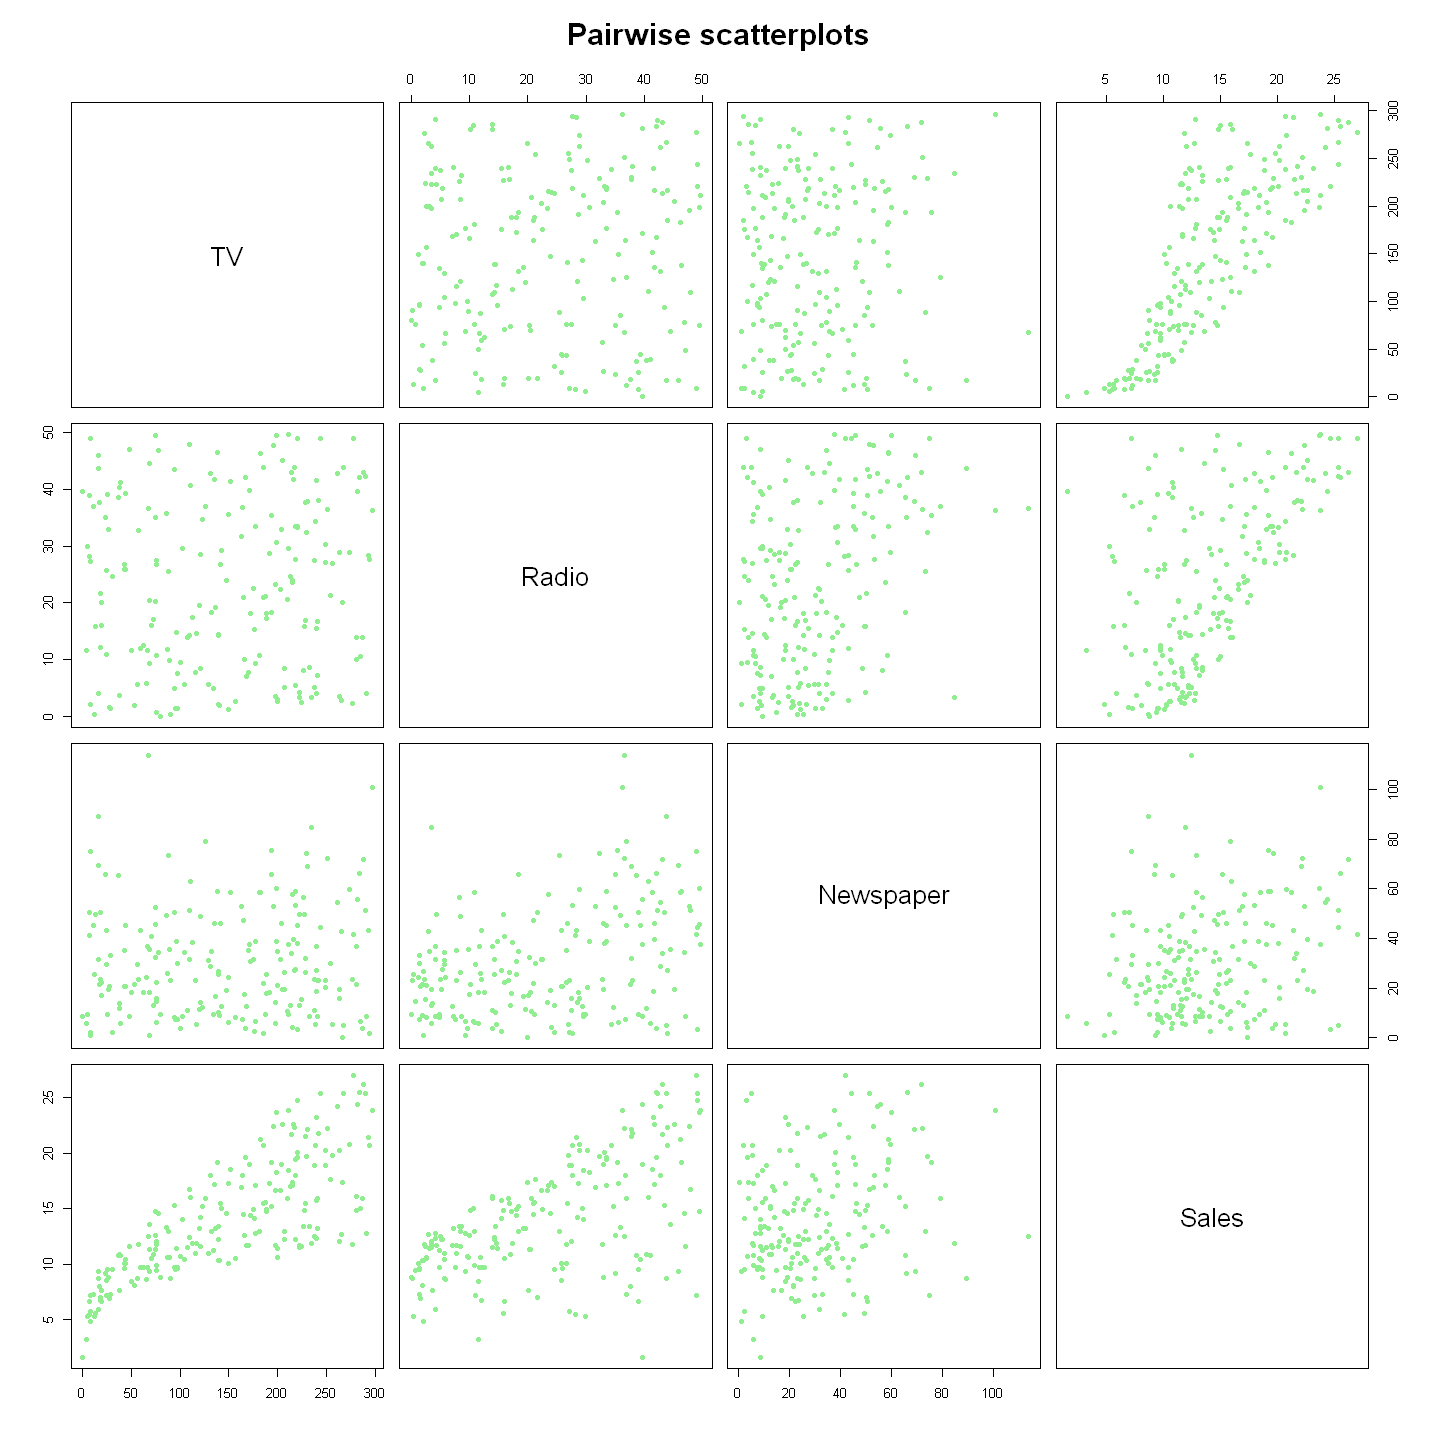

In [31]:
options(repr.plot.width=12, repr.plot.height=12)
plot(Advertising,pch=19,col="LightGreen",cex=0.8,main="Pairwise scatterplots",cex.main=1.5)

In [32]:
#cor(Advertising)
#round(cor(Advertising),2)
round(cor(Advertising),1)

TV  Radio Newspaper Sales
TV        1.0 0.1   0.1       0.8  
Radio     0.1 1.0   0.4       0.6  
Newspaper 0.1 0.4   1.0       0.2  
Sales     0.8 0.6   0.2       1.0

## Multiple regression (classical)

Multiple linear regression of Sales on all three predictors

In [33]:
lm.Advertising.01<-lm(Sales~TV+Radio+Newspaper,data=Advertising)
# Equivalent, alternative notation
#lm.Advertising.01<-lm(Sales~.,data=Advertising)
S<-summary(lm.Advertising.01)
S


Call:
lm(formula = Sales ~ TV + Radio + Newspaper, data = Advertising)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.8277 -0.8908  0.2418  1.1893  2.8292 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.938889   0.311908   9.422   <2e-16 ***
TV           0.045765   0.001395  32.809   <2e-16 ***
Radio        0.188530   0.008611  21.893   <2e-16 ***
Newspaper   -0.001037   0.005871  -0.177     0.86    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.686 on 196 degrees of freedom
Multiple R-squared:  0.8972,	Adjusted R-squared:  0.8956 
F-statistic: 570.3 on 3 and 196 DF,  p-value: < 2.2e-16


In [34]:
anova(lm.Advertising.01)

Df  Sum Sq       Mean Sq      F value      Pr(>F)      
TV          1 3.314618e+03 3.314618e+03 1.166731e+03 1.809337e-84
Radio       1 1.545617e+03 1.545617e+03 5.440501e+02 1.882722e-58
Newspaper   1 8.871717e-02 8.871717e-02 3.122805e-02 8.599151e-01
Residuals 196 5.568253e+02 2.840945e+00           NA           NA

Rename response and model for the sake of pithy expressions

In [35]:
y<-Advertising$Sales
n<-length(y)
# (number of predictors)
p<-3 
# (number of columns in the regression matrix, including the colummn of ones for the intercept)
m<-p+1
p
n

[1] 3

[1] 200

In [36]:
lm.1<-lm.Advertising.01

In [37]:
# Keep the classical intercept (eventually to center the Bayesian prior for the intercept parameter)
beta<-as.numeric(coef(lm.1))
beta0.hat<-beta[1]
round(beta0.hat,4)

[1] 2.9389

$X $ is the matrix with the predictor values for each of the observed samples. 

This is the regression model matrix minus the column of ones corresponding to the intercept.

In [38]:
X<-model.matrix(lm.1)
attr(X,"assign")<-NULL
X<-X[, -1]
#str(X)
head(X)

TV    Radio Newspaper
1 230.1 37.8  69.2     
2  44.5 39.3  45.1     
3  17.2 45.9  69.3     
4 151.5 41.3  58.5     
5 180.8 10.8  58.4     
6   8.7 48.9  75.0

## 04. Bayesian linear regression

## Model

### Likelihood

Each of the  $n$ observed responses $y_{i}$ ($1\leq i\leq n$) is assumed to be drawn from a normal distribution with mean $\mu_{i}$ and standard deviation $\sigma$ (or precision $\tau=1/\sigma^{2}$).

The expected values $\mu_{i}$ are themselves determined by the linear predictor, $\mu_{i}=\beta_{0}+x_{i}\cdot\beta$, $x_{i}\in\mathbb{R}^p$. 

$\beta_{0}$ is the $y$-intercept and each $\beta_{j}\in\R$, $j\geq 1$ represents the rate of change in $y$ for every unit change in the $j$-th effect $x_{j}$ ($1\leq j\leq p$).

$$
\begin{array}{lcl}
        y_{i}         &\sim &\normaldist(\mu_{i},\tau),\\[0.2cm]
        y             &\sim &\normaldist(\mu,\tau), \mskip40mu\text{(in vector notation)}
\end{array}
$$

### Priors

Gaussian (normal) priors centered on zero with relatively large standard deviations for the regression coefficients and a uniform for the standard deviation. 

In JAGS the normal distribution is parameterized with mean and precision $ \tau=1/\sigma^{2}$, hence a noninformative normal prior will have a _small_ precision.

$$
\begin{array}{lcl}
        \mu_{i}       &=    &\beta_{0}+x_{i}\cdot\beta,\mskip20mu 1\leq i\leq n.\\[0.2cm]
        \mu           &=    &\beta_{0}+X\cdot\beta, \mskip20mu\text{(matrix notation)}\\[0.2cm]
        \beta_{0}     &\sim &\normaldist(0,1.0E-6),\\[0.2cm]
        \beta_{j}     &\sim &\normaldist(0,1.0E-6),\mskip20mu 1\leq j\leq p.\\[0.2cm]
        \tau          &=    &1/\sigma^{2},\\[0.2cm]
        \sigma^{2}&\sim &\unifdist(0,100).
\end{array}
$$
  


<h3 style="color:red"> Posterior prediction </h3>

<div style="color:red">
    
We will generate (a sample of) the posterior predictive pdf for just a new $ \widetilde{x}$. 

We do not compute the posterior prediction for the whole set of values in the observed sample, we just choose an example point.
    
For instance, let's take $\widetilde{x}=$ the average row vector of $X$. 
    
$$
\begin{array}{lcl}
    \widetilde{\mu}{\,}^{\text{POST}}   &=    &\beta_{0}{\,}^{\text{POST}}+\tilde{x}_{i}\cdot \beta{\,}^{\text{POST}},\\[0.2cm]
    \widetilde{y}{\,}^{\text{POST}}     &\sim &\normaldist(\widetilde{\mu}{\,}^{\text{POST}},{\sigma^{2}}{\,}^{\text{POST}}).
\end{array}
$$
    
</div>

In [39]:
x.tilde<-colMeans(X)
round(x.tilde,2)

TV     Radio Newspaper 
   147.04     23.26     30.55

## JAGS code 

In [40]:
Advertising.Pred.JAGS.01.modelString = "
    model {
    #Likelihood
    for (i in 1:n) {
        y[i]~dnorm(mu[i],tau)
         mu[i] <- beta0 + inprod(beta[],X[i,])
        }
  
    #Priors
    beta0 ~ dnorm(0.0,1.0E-6)
    for (j in 1:p) {
        beta[j] ~ dnorm(0.0,1.0E-6)
        }
    tau<-pow(sigma,-2)
    sigma~dunif(0,100)

    #Posterior prediction
    mu.tilde<-beta0+inprod(beta[],x.tilde[])
    y.tilde~dnorm(mu.tilde,tau)
  }
  "

## write the model to text file 
writeLines(Advertising.Pred.JAGS.01.modelString, con = "./Advertising.Pred.JAGS.01.jag")

In [41]:
Advertising.Pred.JAGS.01.data.list <- list(y = y, X = X, p = p, n = n, x.tilde = x.tilde)

In [42]:
Advertising.Pred.JAGS.01.params <- c("beta0", "beta", "sigma","mu.tilde","y.tilde")
nChains = 3
burnInSteps = 3000
thinSteps = 5
numSavedSteps = 15000  #across all chains
nIter = ceiling(burnInSteps + (numSavedSteps * thinSteps)/nChains)
nIter

[1] 28000

In [43]:
Advertising.Pred.JAGS.01.m <- jags(data = Advertising.Pred.JAGS.01.data.list, inits = NULL, 
                                   parameters.to.save = Advertising.Pred.JAGS.01.params,
    model.file = "./Advertising.Pred.JAGS.01.jag", n.chains = nChains, n.iter = nIter,
    n.burnin = burnInSteps, n.thin = thinSteps)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 6
   Total graph size: 1421

Initializing model



## Summary of JAGS output

In [44]:
print(Advertising.Pred.JAGS.01.m)

Inference for Bugs model at "./Advertising.Pred.JAGS.01.jag", fit using jags,
 3 chains, each with 28000 iterations (first 3000 discarded), n.thin = 5
 n.sims = 15000 iterations saved
         mu.vect sd.vect    2.5%     25%     50%     75%   97.5%  Rhat n.eff
beta[1]    0.046   0.001   0.043   0.045   0.046   0.047   0.049 1.001 15000
beta[2]    0.189   0.009   0.172   0.183   0.188   0.194   0.206 1.001 15000
beta[3]   -0.001   0.006  -0.013  -0.005  -0.001   0.003   0.011 1.001 14000
beta0      2.937   0.313   2.325   2.728   2.940   3.152   3.539 1.001 15000
mu.tilde  14.023   0.120  13.789  13.941  14.022  14.104  14.260 1.001 15000
sigma      1.695   0.087   1.535   1.635   1.693   1.752   1.876 1.001 15000
y.tilde   14.030   1.690  10.668  12.916  14.039  15.154  17.353 1.001 15000
deviance 777.486   3.216 773.211 775.103 776.867 779.131 785.446 1.001  5500

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (a

#### Compare with classical solution coefficients

In [45]:
round(S$coefficients[c(2,3,4,1),],5)

Estimate Std. Error t value  Pr(>|t|)
TV           0.04576 0.00139    32.80862 0.00000 
Radio        0.18853 0.00861    21.89350 0.00000 
Newspaper   -0.00104 0.00587    -0.17671 0.85992 
(Intercept)  2.93889 0.31191     9.42229 0.00000

In [46]:
round(sigma(lm.1),5)

[1] 1.68551

In [47]:
round(S$r.squared,5)

[1] 0.89721

In [48]:
A<-anova(lm.1)
A

Df  Sum Sq       Mean Sq      F value      Pr(>F)      
TV          1 3.314618e+03 3.314618e+03 1.166731e+03 1.809337e-84
Radio       1 1.545617e+03 1.545617e+03 5.440501e+02 1.882722e-58
Newspaper   1 8.871717e-02 8.871717e-02 3.122805e-02 8.599151e-01
Residuals 196 5.568253e+02 2.840945e+00           NA           NA

In [49]:
str(A)

Classes 'anova' and 'data.frame':	4 obs. of  5 variables:
 $ Df     : int  1 1 1 196
 $ Sum Sq : num  3.31e+03 1.55e+03 8.87e-02 5.57e+02
 $ Mean Sq: num  3.31e+03 1.55e+03 8.87e-02 2.84
 $ F value: num  1.17e+03 5.44e+02 3.12e-02 NA
 $ Pr(>F) : num  1.81e-84 1.88e-58 8.60e-01 NA
 - attr(*, "heading")= chr [1:2] "Analysis of Variance Table\n" "Response: Sales"


In [50]:
SS<-A$Sum
round(SS,5)

[1] 3314.61817 1545.61660    0.08872  556.82526

#### Compare the average of the posterior predictive pdf to the classical estimate

We could also compare the clasical confidence interval for the predicted value to a credible interval for the posterior predicted

In [51]:
beta0.clas<-S$coefficients[1]
beta.clas<-S$coefficients[2:4]
y.tilde.clas.pred<-beta0.clas+sum(beta.clas*x.tilde)
round(y.tilde.clas.pred,3)

[1] 14.023

#### Convert to a coda `mcmc` object

In [52]:
Advertising.Pred.JAGS.01.mcmc<-as.mcmc(Advertising.Pred.JAGS.01.m)
summary(Advertising.Pred.JAGS.01.mcmc)


Iterations = 3001:27996
Thinning interval = 5 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

               Mean       SD  Naive SE Time-series SE
beta[1]    0.045771 0.001415 1.155e-05      1.154e-05
beta[2]    0.188548 0.008689 7.095e-05      7.095e-05
beta[3]   -0.001006 0.005943 4.852e-05      4.913e-05
beta0      2.937487 0.312655 2.553e-03      2.525e-03
deviance 777.486245 3.215688 2.626e-02      2.606e-02
mu.tilde  14.023467 0.120110 9.807e-04      9.821e-04
sigma      1.695491 0.086885 7.094e-04      7.149e-04
y.tilde   14.030312 1.690199 1.380e-02      1.398e-02

2. Quantiles for each variable:

              2.5%        25%        50%       75%     97.5%
beta[1]    0.04297   0.044818   0.045763 4.672e-02   0.04856
beta[2]    0.17166   0.182718   0.188496 1.945e-01   0.20564
beta[3]   -0.01261  -0.004996  -0.001005 2.989e-03   0.01067
beta0      2.32480   2.728210   2.9399

In [53]:
#install.packages("bayesplot",dependencies=TRUE,repos= "https://cloud.r-project.org")
require(bayesplot)

### Traceplot

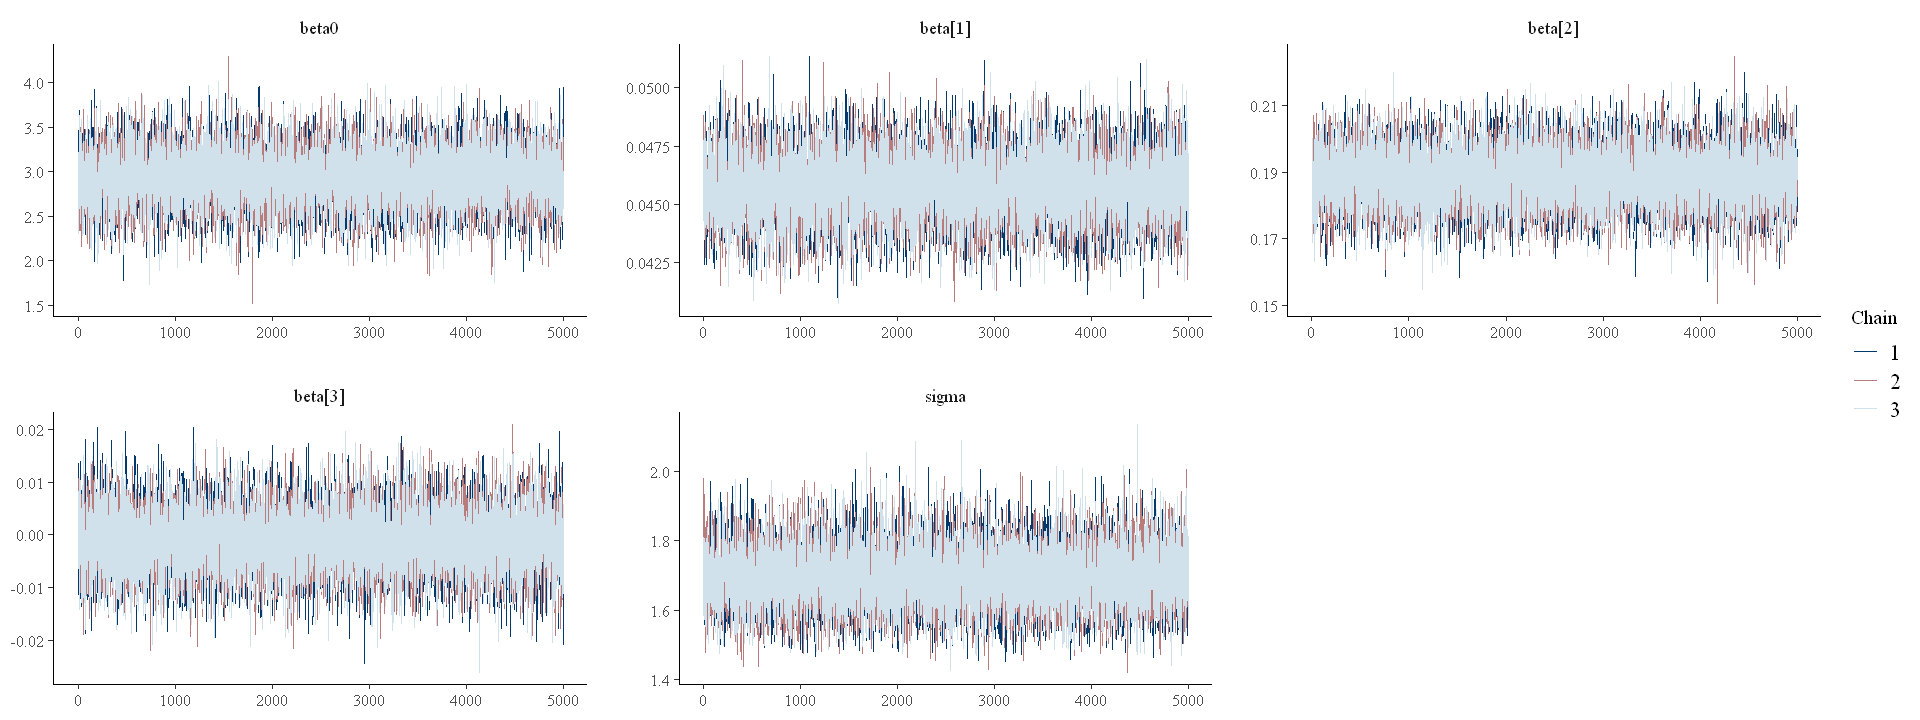

In [54]:
options(repr.plot.width=16, repr.plot.height=6)
color_scheme_set("mix-blue-red")
mcmc_trace(Advertising.Pred.JAGS.01.mcmc, pars = c("beta0","beta[1]","beta[2]","beta[3]","sigma"))

Here one way to list all `beta` parameters

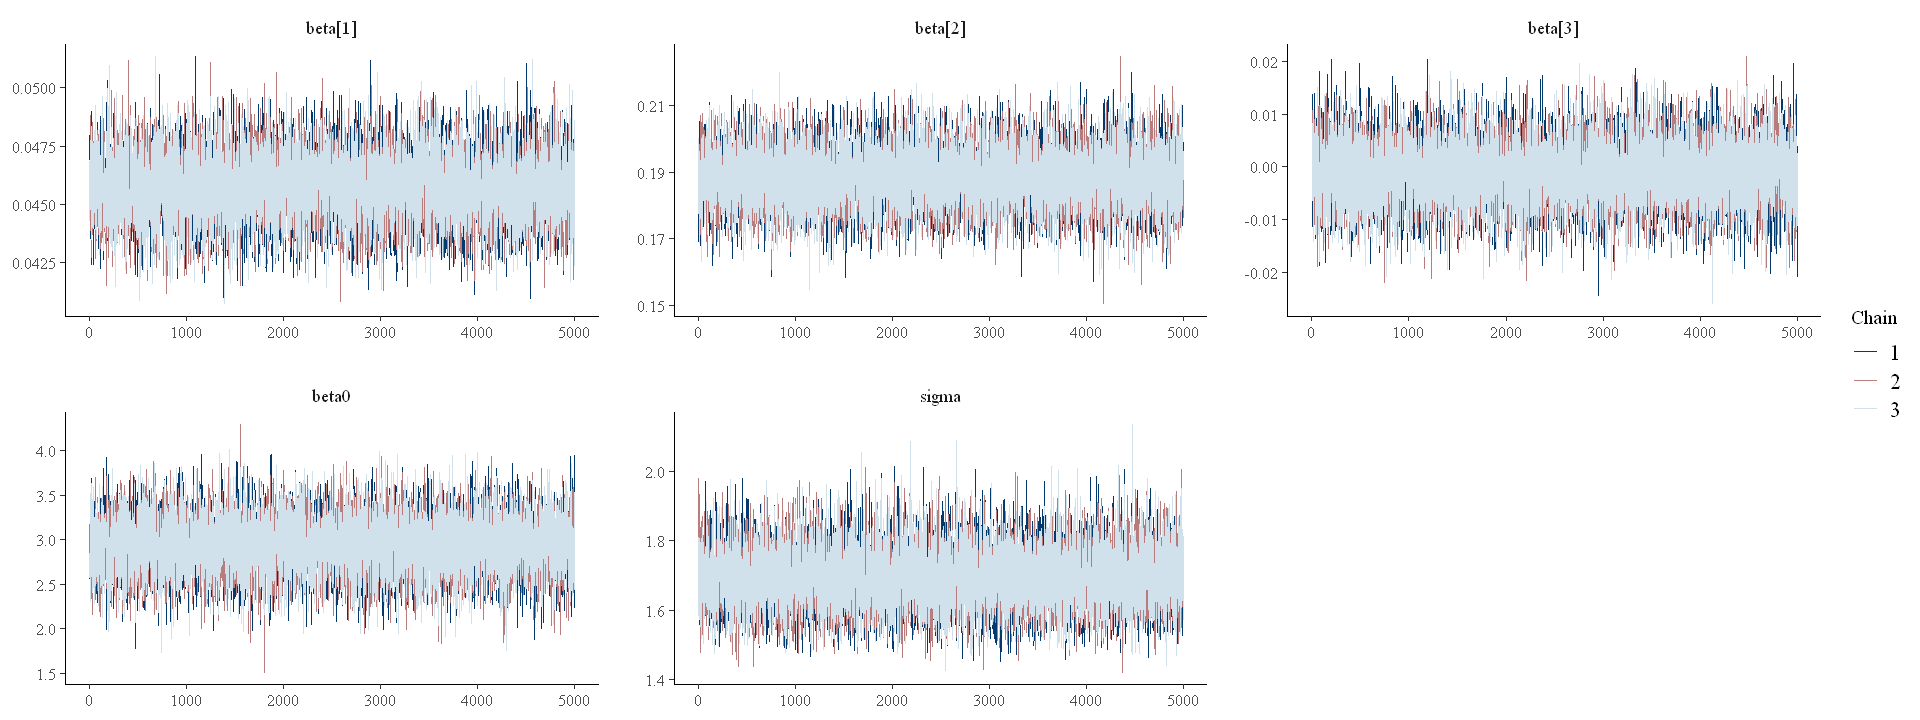

In [55]:
options(repr.plot.width=16, repr.plot.height=6)
color_scheme_set("mix-blue-red")
mcmc_trace(Advertising.Pred.JAGS.01.mcmc, pars = c(vars(starts_with("beta"),"sigma")))

### Autocorrelation plot

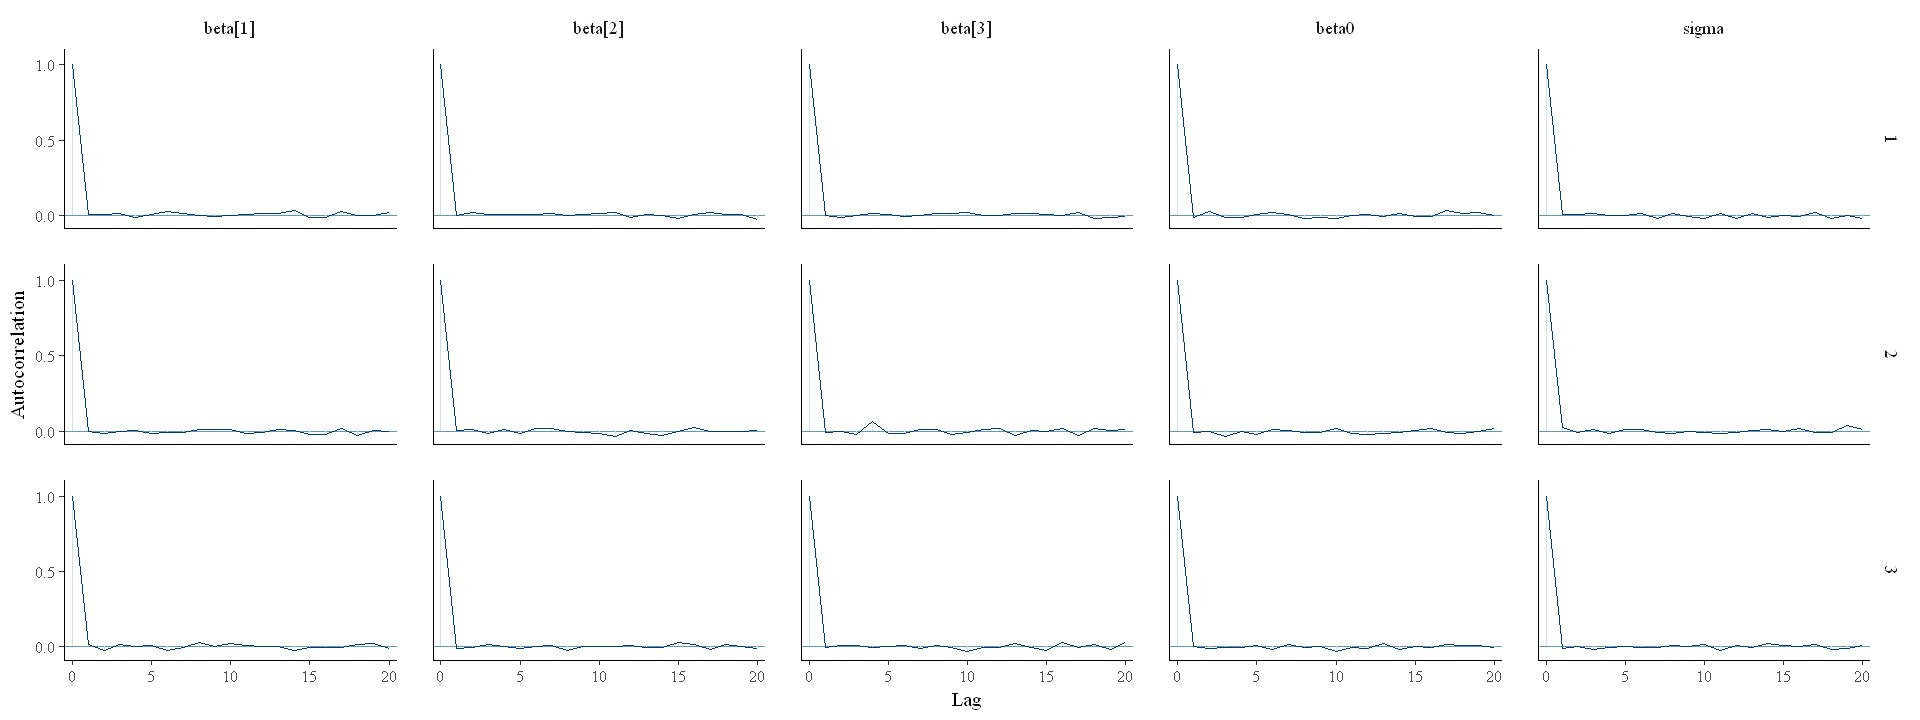

In [56]:
options(repr.plot.width=16, repr.plot.height=6)
color_scheme_set("blue")
mcmc_acf(Advertising.Pred.JAGS.01.mcmc, pars = c(vars(starts_with("beta"),"sigma")))

###  Posterior area plots (posterior density + posterior credible intervals)

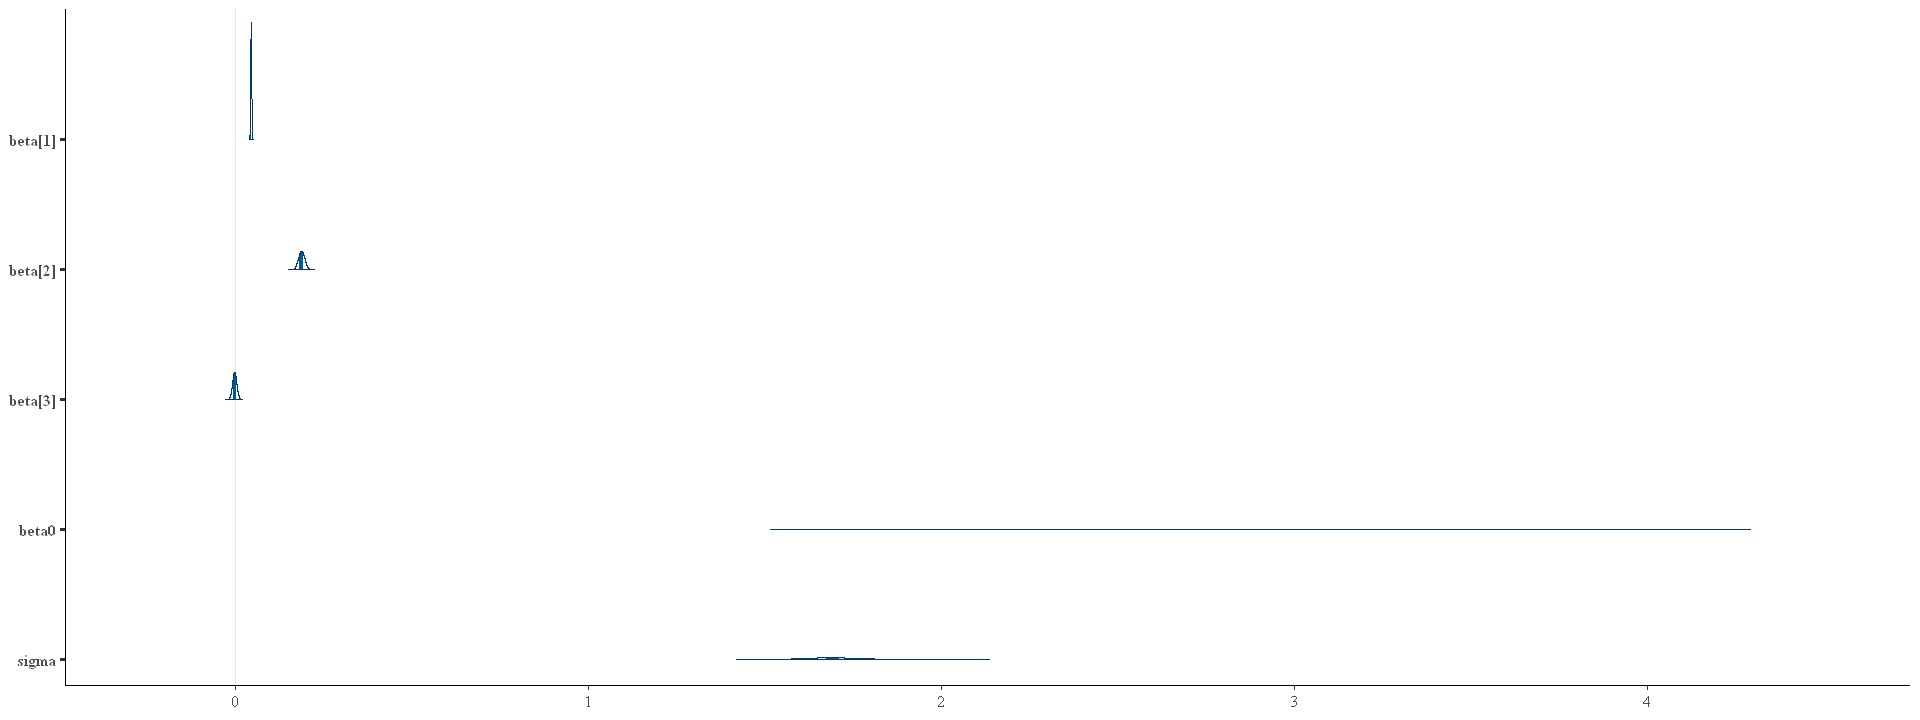

In [57]:
options(repr.plot.width=16, repr.plot.height=6)
color_scheme_set("mix-blue-red")
mcmc_areas(Advertising.Pred.JAGS.01.mcmc, pars = c(vars(starts_with("beta"),"sigma")))

Problem with plotting parameters together is, either range or dispersion can be quite different.

Then one can plot them separately to better visualize.

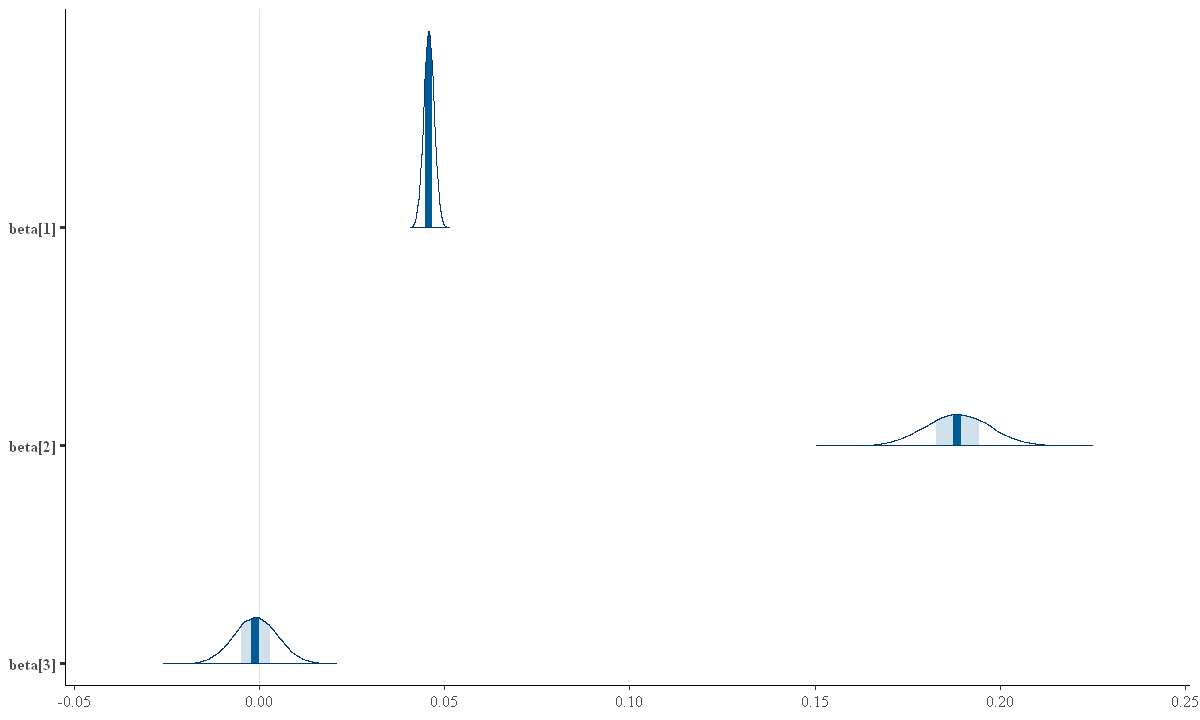

In [58]:
options(repr.plot.width=10, repr.plot.height=6)
color_scheme_set("mix-blue-red")
mcmc_areas(Advertising.Pred.JAGS.01.mcmc, pars = vars(starts_with("beta[")))

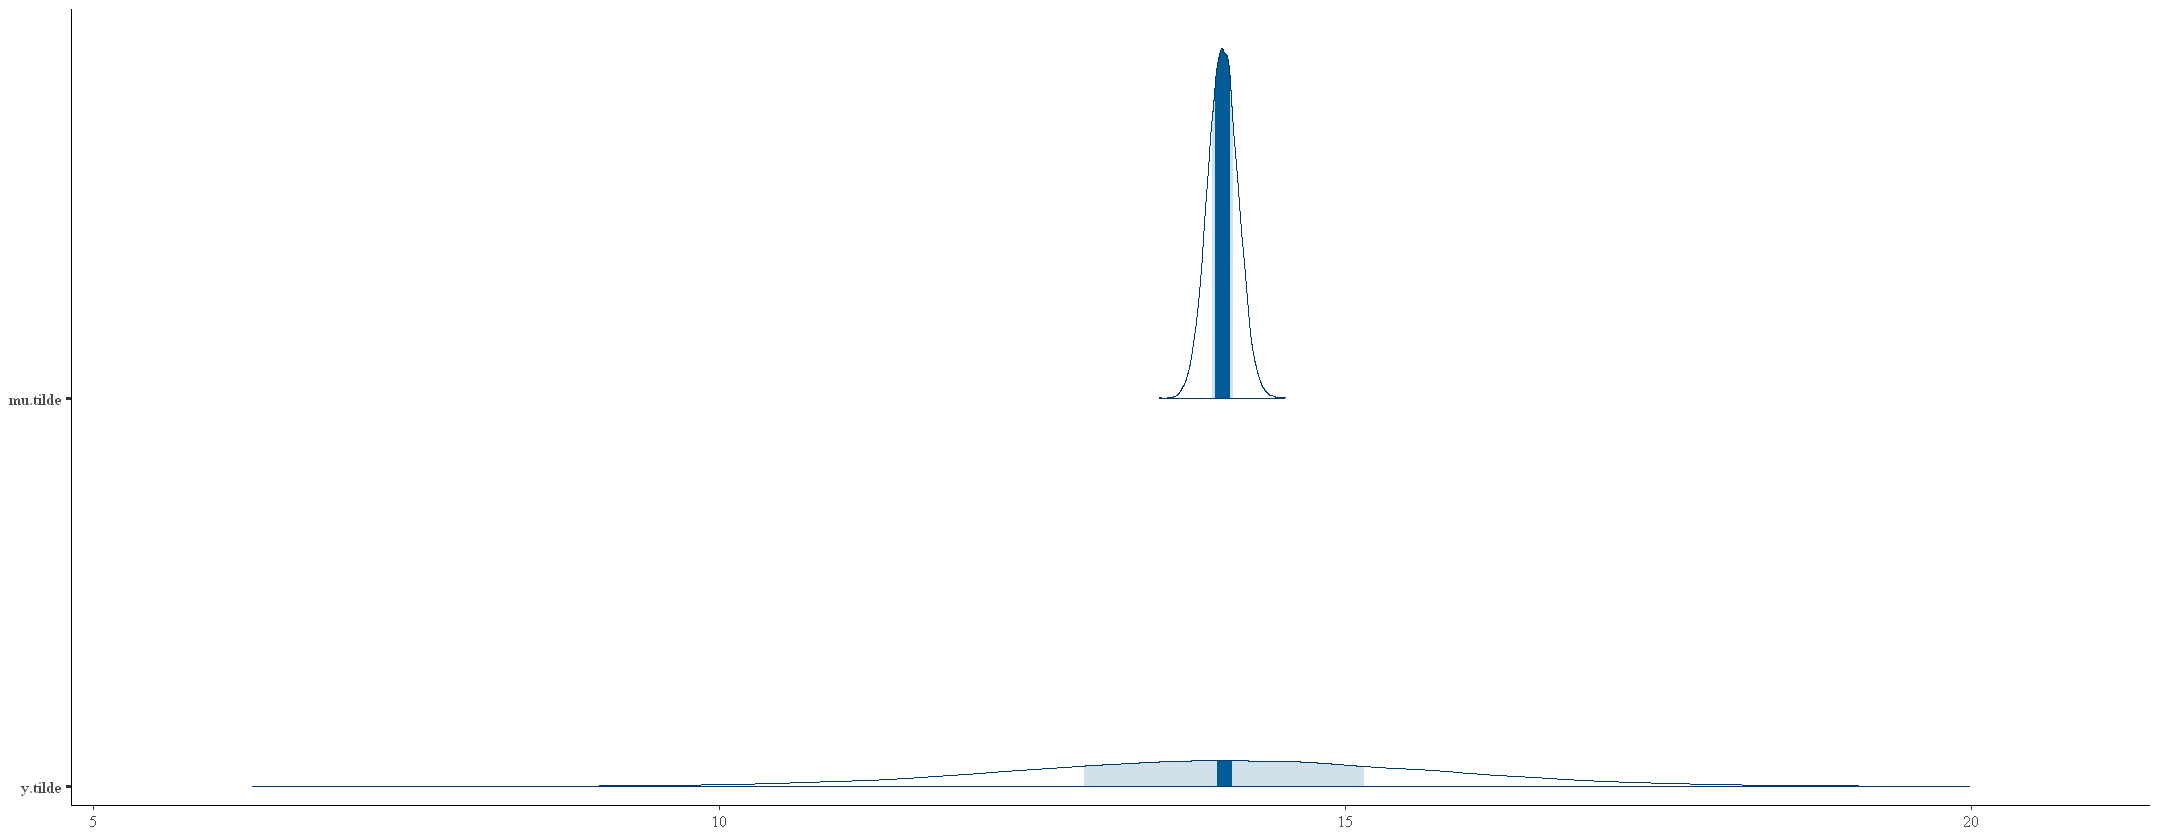

In [59]:
options(repr.plot.width=18, repr.plot.height=7)
color_scheme_set("blue")
mcmc_areas(Advertising.Pred.JAGS.01.mcmc, pars = c("mu.tilde","y.tilde"))

Predicted `y.tilde` has two sources of uncertainty: that of the regression coefficients `beta` plus that of the generated `y`.

When both quantities are represented separately, this information is lost.

###  Posterior density plots

In [60]:
options(repr.plot.width=16, repr.plot.height=6)
color_scheme_set("brightblue")
mcmc_dens(Advertising.Pred.JAGS.01.mcmc, pars = c("mu.tilde","y.tilde"))